In [1]:
import gutenbergpy.textget
from catboost import CatBoostClassifier, Pool
import shap
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('punkt')  # Download necessary data
nltk.download('stopwords')
import string
import re
from nltk import FreqDist
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
    roc_auc_score,
    ConfusionMatrixDisplay)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
from belt_nlp.bert_with_pooling import BertClassifierWithPooling
import seaborn as sns
import umap

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taylan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taylan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def get_text(id):
    # This gets a book by its gutenberg id number
    raw_book = gutenbergpy.textget.get_text_by_id(id) # with headers
    clean_book = gutenbergpy.textget.strip_headers(raw_book) # without headers
    return clean_book, raw_book
def clean_tokenize_filter(text):
  text = text.decode('utf-8')
  words = text.split()

  # Clean and join the words while preserving spaces
  # Clean and join the words while preserving spaces and apostrophes
  cleaned_text = ' '.join([re.sub(r'[^a-zA-Z0-9\s\'".?!,:;()-]', '', word) for word in words])
  cleaned_text = cleaned_text.replace("'","")
  cleaned_text = cleaned_text.lower()

  # Tokenize the text
  tokens = word_tokenize(cleaned_text)

  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
  filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
  filtered_tokens = [re.sub(r'[%s]+' % re.escape(string.punctuation), '', word) for word in filtered_tokens]
  # Remove empty strings resulting from removing punctuation
  filtered_tokens = [word for word in filtered_tokens if word and not word.isspace()]

  # Join the filtered tokens back into a single cleaned_text
  filtered_text = ' '.join(filtered_tokens)
  return cleaned_text, tokens, filtered_tokens, filtered_text
def encode_decode_text(text, target_encoding='utf-8'):
    try:
        # Attempt to decode the text using the target encoding
        decoded_text = text.decode(target_encoding)

        # If decoding is successful, return the decoded text
        return decoded_text
    except UnicodeDecodeError:
        # If decoding fails, assume the text is already in the target encoding
        return text.encode(target_encoding)
def process_df(df,author_list):
  processed_df = df[
    (df["Audio"] != "Audio\xa0\xa0") &
    (df["Language"] == "English") &
    (df["Author"].isin(author_list))
    ].reset_index()
  processed_df["Etext-No."] = processed_df["Etext-No."].astype(int)
  processed_df["Author"] = processed_df["Author"].apply(lambda x: x.split(", 1")[0])
  return processed_df

def get_middle_section_by_pct(input_string, percentage):
    words = input_string.split()
    total_words = len(words)
    middle_word_count = int(total_words * percentage)
    start_word = max(0, (total_words - middle_word_count) // 2)
    end_word = start_word + middle_word_count
    middle_words = ' '.join(words[start_word:end_word])
    return middle_words

def get_middle_section_by_words(input_string, num_words):
    words = input_string.split()
    middle_index = len(words) // 2
    return ' '.join(words[max(0, middle_index - num_words // 2):middle_index + num_words // 2])

def prepare_dictionary(clean_df, chunk_pct = None):
  dictionary = {}
  for author in list(clean_df["Author"].unique()):
    dictionary[author] = {}
  all_text = " ".encode('utf-8')
  for i,row in clean_df.loc[:].iterrows():
    no = row["Etext-No."]
    author, title = clean_df.loc[i,["Author","Title"]].values
    try:
      text, raw = get_text(no)
      if chunk_pct:
        try:
          text = text[len(text)//2 - chunk_pct:len(text)//2 + chunk_pct]
        except:
          print("can't get chunk")
          pass
      cleaned_text, tokens, filtered_tokens, filtered_text = clean_tokenize_filter(text)
      print(author,title," successfull")
      dictionary[author][title] = {"cleaned_text":cleaned_text, "tokens": tokens, "filtered_tokens": filtered_tokens, "filtered_text": filtered_text}
      all_text = all_text + text
    except:
      print(author,title," failed")
      pass
  text = text.decode('utf-8')
  return dictionary, all_text

def plot_pie_chart(dictionary, title):
  work_length_dict = {author: 0 for author in dictionary.keys()}
  for author in dictionary.keys():
    for work in dictionary[author].keys():
      work_length_dict[author] += len(dictionary[author][work]["filtered_text"].split(" "))

  df = pd.DataFrame.from_dict(work_length_dict, orient='index', columns=["Total Words"])
  ax = df.plot.pie(y="Total Words", figsize=(8, 6), legend=False, autopct='%1.1f%%', title=title)
  ax.set_ylabel('')

def undersample_df(df, target_column_name):
    majority_class = df[df[target_column_name] == 0]
    minority_class = df[df[target_column_name] == 1]
    minority_class_size = len(minority_class)
    undersampled_majority = resample(majority_class, replace=False, n_samples=minority_class_size, random_state=42)
    undersampled_df = pd.concat([undersampled_majority, minority_class])
    undersampled_df = undersampled_df.sample(frac=1, random_state=42)

    return undersampled_df

def print_classification_metrics(y_test, predictions, labels):
    # Calculate and print various classification metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cohen_kappa = cohen_kappa_score(y_test, predictions)
    matthews_corr = matthews_corrcoef(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    #cm = confusion_matrix(y_test, predictions, labels=labels)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Cohen's Kappa: {cohen_kappa:.2f}")
    print(f"Matthew's Correlation Coefficient: {matthews_corr:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")

    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, predictions))

    #disp.plot()

def print_split_stats(X_train, X_val, X_test, y_train, y_val, y_test, train, val, test):
  print("data target dist =\n",data["Target"].value_counts()/sum(data["Target"].value_counts()))
  total_samples = train.shape[0] + test.shape[0] + val.shape[0] + 1e-10
  print("train val test ratio = ",train.shape[0] / total_samples, val.shape[0] / total_samples, test.shape[0] / total_samples, )
  print("train val test target dist = ",train["Target"].value_counts()/sum(train["Target"].value_counts()),val["Target"].value_counts()/sum(val["Target"].value_counts()),test["Target"].value_counts()/sum(test["Target"].value_counts()))
  print("X_train shape = {}\n X_val shape = {}\n X_test shape = {}\n y_train shape = {}\n y_val shape = {}\n y_test shape = {}\n train shape = {}\n test shape = {}".format(X_train.shape,X_val .shape ,X_test .shape, y_train.shape, y_val.shape, y_test.shape, train.shape, test.shape))
  return train["Target"].value_counts()/sum(train["Target"].value_counts()),val["Target"].value_counts()/sum(val["Target"].value_counts()),test["Target"].value_counts()/sum(test["Target"].value_counts())

Load

In [3]:
with open("sad.pkl", 'rb') as pickle_file:
    sad_all_text, sad_dict = pickle.load(pickle_file)
with open("happy.pkl", 'rb') as pickle_file:
    happy_all_text, happy_dict = pickle.load(pickle_file)

Process Data for ML

In [4]:
# Read the dictionaries, append, create df
texts = []
for author in sad_dict.keys():
  for work in sad_dict[author].keys():
    texts.append([author,work,sad_dict[author][work]["cleaned_text"],1])
for author in happy_dict.keys():
  for work in happy_dict[author].keys():
    texts.append([author,work,happy_dict[author][work]["cleaned_text"],0])
data = pd.DataFrame(texts, columns = ["Author","Work","Text","Target"])

# Remove illustration phrases used for pictures
data["Text"] = data["Text"].apply(lambda x: x.replace("illustration",""))

# Get the 0.8 middle chunk of the text to avoid Project Gutenberg information
data["Text"] = data["Text"].apply(lambda x : get_middle_section_by_pct(x,0.8))

# Calculate Total Words and Chars
data["Words"] = data["Text"].apply(lambda x : len(x.split(" ")))
data["Chars"] = data["Text"].apply(lambda x : len(x))

print(data.shape)

(655, 6)


In [5]:
del texts

In [6]:
del sad_all_text
del happy_all_text

In [7]:
df_author_grouped = pd.concat([data.groupby("Author")["Text"].sum().reset_index(),
                               data.groupby("Author")["Target"].mean().astype(int).reset_index(drop = True),
                               data.groupby("Author")["Work"].size().reset_index(drop = True),

],1).rename(columns = {"Work":"Works"})
df_author_grouped["Words"] = df_author_grouped["Text"].apply(lambda x : len(x.split(" ")))
df_author_grouped["Chars"] = df_author_grouped["Text"].apply(lambda x : len(x))
df_author_grouped = df_author_grouped.sort_values(["Target","Words"]).reset_index(drop = True)


df_author_grouped = df_author_grouped[~df_author_grouped["Author"].isin(["Twain, Mark","Dickens, Charles"])].reset_index(drop = True)

df_author_grouped
author_info_cumulative = pd.concat([df_author_grouped,pd.concat([df_author_grouped[df_author_grouped["Target"] == 0][::-1].cumsum(),df_author_grouped[df_author_grouped["Target"] == 1][::-1].cumsum()])[["Words"]]
                                    ,pd.concat([df_author_grouped[df_author_grouped["Target"] == 0][::-1].cumsum(),df_author_grouped[df_author_grouped["Target"] == 1][::-1].cumsum()])[["Works"]]
                                    ],1)
author_info_cumulative.columns = ["Author","Text","Target","Works","Words","Chars","Words_cumsum","Works_cumsum"]
author_info_cumulative["Word_cumsum_pct"] = pd.concat([author_info_cumulative[author_info_cumulative["Target"] == 0] ["Words_cumsum"] / author_info_cumulative.loc[author_info_cumulative["Target"] == 0,"Words_cumsum"].max(),
           author_info_cumulative[author_info_cumulative["Target"] == 1] ["Words_cumsum"] / author_info_cumulative.loc[author_info_cumulative["Target"] == 1,"Words_cumsum"].max() ] )

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


Decide the Splits

Random sampling brute force to find a balanced author split

In [ ]:
%%capture
from random import sample
params_scores = []
for aq in range(2,7):
  for bq in range(2,10-aq):
    for _ in range(100):
      try:
        indexes_0 = author_info_cumulative[author_info_cumulative["Target"] == 0].index.values
        indexes_1 = author_info_cumulative[author_info_cumulative["Target"] == 1].index.values
        all_indexes = author_info_cumulative.index.values

        chosen_test_indexes = np.concatenate([np.random.choice(indexes_0, aq, replace = False), np.random.choice(indexes_1, bq, replace = False)])
        chosen_train_indexes = np.delete(all_indexes, chosen_test_indexes)

        train_dict = {i:"train" for i in author_info_cumulative.iloc[np.r_[chosen_train_indexes]]["Author"].values}
        test_dict = {i:"test" for i in author_info_cumulative.iloc[np.r_[chosen_test_indexes]]["Author"].values}
        author_split_dict = train_dict | test_dict
        #print(author_split_dict)
        author_info_cumulative["Split"] = author_info_cumulative["Author"].map(author_split_dict)
        data["Split"] = data["Author"].map(author_split_dict)
        df = data.copy()
        train, test = df[df["Split"] == "train"], df[df["Split"] == "test"]
        X_train, X_test = train["Text"].values, test["Text"].values
        y_train, y_test = train["Target"].values, test["Target"].values
        x,y = print_split_stats(X_train, X_test , y_train, y_test, train, test)
        score = np.abs(x[0] - 0.5) + np.abs(y[0] - 0.5)
        params_scores.append([author_split_dict,len(train_dict),len(test_dict),x[0],y[0],score])
        #print(test)
      except:
        pass

In [10]:
%%capture
from random import sample
params_scores = []
indexes = []
doubles = []
chosen_train_indexes,chosen_val_indexes,chosen_test_indexes = [1,2], [3,4], [5,6]
for aq in range(1,8):
  for bq in range(1,8):
    for cq in range(1,8):
      for dq in range(1,8):
        for _ in range(100):
          if [chosen_train_indexes,chosen_val_indexes,chosen_test_indexes] not in params_scores: 
            try:
              indexes_0 = author_info_cumulative[author_info_cumulative["Target"] == 0].index.values
              indexes_1 = author_info_cumulative[author_info_cumulative["Target"] == 1].index.values
              all_indexes = author_info_cumulative.index.values

              chosen_test_indexes = np.concatenate([np.random.choice(indexes_0, aq, replace = False), np.random.choice(indexes_1, bq, replace = False)])
              chosen_train_indexes = np.delete(all_indexes, chosen_test_indexes)

              chosen_train_indexes_0, chosen_train_indexes_1 = np.intersect1d(chosen_train_indexes, indexes_0), np.intersect1d(chosen_train_indexes, indexes_1)
              chosen_val_indexes = np.concatenate([np.random.choice(chosen_train_indexes_0, cq, replace = False), np.random.choice(chosen_train_indexes_1, dq, replace = False)])
          
              chosen_train_indexes = np.delete(chosen_train_indexes, chosen_val_indexes)


              train_dict = {i:"train" for i in author_info_cumulative.iloc[np.r_[chosen_train_indexes]]["Author"].values}
              test_dict = {i:"test" for i in author_info_cumulative.iloc[np.r_[chosen_test_indexes]]["Author"].values}
              val_dict = {i:"val" for i in author_info_cumulative.iloc[np.r_[chosen_val_indexes]]["Author"].values}

              author_split_dict = train_dict | test_dict | val_dict
              #print(author_split_dict)
              author_info_cumulative["Split"] = author_info_cumulative["Author"].map(author_split_dict)
              data["Split"] = data["Author"].map(author_split_dict)
              df = data.copy()
              train, test, val = df[df["Split"] == "train"], df[df["Split"] == "test"], df[df["Split"] == "val"]
              X_train, X_val, X_test = train["Text"].values, val["Text"].values, test["Text"].values
              y_train, y_val, y_test = train["Target"].values, val["Target"].values,test["Target"].values

              x,y,z = print_split_stats(X_train, X_val, X_test , y_train, y_val, y_test, train, val, test)
              score = np.abs(x[0] - 0.5) + np.abs(y[0] - 0.5) +  np.abs(z[0] - 0.5)
              params_scores.append([author_split_dict,len(train_dict),len(val_dict),len(test_dict),x[0],y[0],z[0],score])
              indexes.append([chosen_train_indexes,chosen_val_indexes,chosen_test_indexes])
              #print(test)
            except:
              pass
          else:
            doubles.append([chosen_train_indexes,chosen_val_indexes,chosen_test_indexes])    

In [11]:
params_scores = pd.DataFrame(params_scores, columns = ["dict","nof_train_authors","nof_val_authors","nof_test_authors","train_balance","val_balance","test_balance","score"])
params_scores = params_scores[(params_scores["nof_train_authors"] > params_scores["nof_test_authors"]) & (params_scores["nof_train_authors"] > params_scores["nof_val_authors"])].sort_values("score").reset_index(drop = True)
optimal_dict, optimal_score = params_scores.iloc[0,0], params_scores.iloc[0,1]
print(optimal_dict)
params_scores.head(10)

{'Christie, Agatha': 'train', 'Milne, A. A. (Alan Alexander)': 'train', 'Shakespeare, William': 'train', 'Austen, Jane': 'val', 'Alcott, Louisa May': 'train', 'Verne, Jules': 'train', 'Verlaine, Paul': 'val', 'Nerval, Gérard de': 'train', 'Berryman, John': 'val', 'Kafka, Franz': 'train', 'Zweig, Stefan': 'train', 'Woolf, Virginia': 'val', 'Fitzgerald, F. Scott (Francis Scott)': 'train', 'Nietzsche, Friedrich Wilhelm': 'train', 'Dostoyevsky, Fyodor': 'train', 'London, Jack': 'train', 'Tolstoy, Leo, graf': 'train', 'Potter, Beatrix': 'test', 'Hemingway, Ernest': 'test', 'Poe, Edgar Allan': 'test', 'Westlake, Donald E.': 'val', 'Peck, Harry Thurston': 'val'}


,dict,nof_train_authors,nof_val_authors,nof_test_authors,train_balance,val_balance,test_balance,score
0,"{'Christie, Agatha': 'train', 'Milne, A. A. (A...",17,6,3,0.547904,0.483871,0.511628,0.075661
1,"{'Westlake, Donald E.': 'train', 'Christie, Ag...",18,6,2,0.530201,0.536585,0.478261,0.088526
2,"{'Christie, Agatha': 'val', 'Shakespeare, Will...",18,5,3,0.504587,0.541667,0.554622,0.100876
3,"{'Westlake, Donald E.': 'train', 'Potter, Beat...",17,3,6,0.569767,0.550000,0.500000,0.119767
4,"{'Potter, Beatrix': 'train', 'Christie, Agatha...",18,6,2,0.531646,0.517857,0.571429,0.120931
5,"{'Westlake, Donald E.': 'train', 'Christie, Ag...",15,3,8,0.504630,0.578947,0.538462,0.122039
6,"{'Potter, Beatrix': 'train', 'Christie, Agatha...",19,4,3,0.512605,0.568627,0.540816,0.122049
7,"{'Potter, Beatrix': 'train', 'Christie, Agatha...",14,6,6,0.510870,0.483871,0.602151,0.129149
8,"{'Westlake, Donald E.': 'train', 'Christie, Ag...",19,5,2,0.594203,0.486486,0.478261,0.129456
9,"{'Westlake, Donald E.': 'train', 'Potter, Beat...",18,4,4,0.623100,0.500000,0.490000,0.133100


In [12]:
print(params_scores.iloc[0,0]), print(params_scores.iloc[1,0]), print(params_scores.iloc[2,0])

{'Christie, Agatha': 'train', 'Milne, A. A. (Alan Alexander)': 'train', 'Shakespeare, William': 'train', 'Austen, Jane': 'val', 'Alcott, Louisa May': 'train', 'Verne, Jules': 'train', 'Verlaine, Paul': 'val', 'Nerval, Gérard de': 'train', 'Berryman, John': 'val', 'Kafka, Franz': 'train', 'Zweig, Stefan': 'train', 'Woolf, Virginia': 'val', 'Fitzgerald, F. Scott (Francis Scott)': 'train', 'Nietzsche, Friedrich Wilhelm': 'train', 'Dostoyevsky, Fyodor': 'train', 'London, Jack': 'train', 'Tolstoy, Leo, graf': 'train', 'Potter, Beatrix': 'test', 'Hemingway, Ernest': 'test', 'Poe, Edgar Allan': 'test', 'Westlake, Donald E.': 'val', 'Peck, Harry Thurston': 'val'}
{'Westlake, Donald E.': 'train', 'Christie, Agatha': 'val', 'Shakespeare, William': 'train', 'Austen, Jane': 'val', 'Alcott, Louisa May': 'train', 'Verne, Jules': 'train', 'Verlaine, Paul': 'train', 'Sterling, George': 'train', 'Nerval, Gérard de': 'train', 'Berryman, John': 'train', 'Peck, Harry Thurston': 'train', 'Woolf, Leonard': 

(None, None, None)

In [14]:
print(params_scores.iloc[3,0])

{'Westlake, Donald E.': 'train', 'Potter, Beatrix': 'train', 'Christie, Agatha': 'train', 'Shakespeare, William': 'train', 'Austen, Jane': 'val', 'Verne, Jules': 'train', 'Verlaine, Paul': 'train', 'Sterling, George': 'train', 'Nerval, Gérard de': 'train', 'Berryman, John': 'train', 'Woolf, Leonard': 'train', 'Kafka, Franz': 'val', 'Zweig, Stefan': 'train', 'Woolf, Virginia': 'val', 'Poe, Edgar Allan': 'train', 'Nietzsche, Friedrich Wilhelm': 'train', 'London, Jack': 'train', 'Milne, A. A. (Alan Alexander)': 'test', 'Wodehouse, P. G. (Pelham Grenville)': 'test', 'Hemingway, Ernest': 'test', 'Tolstoy, Leo, graf': 'test', 'Baldwin, James': 'test', 'Peck, Harry Thurston': 'test'}


Choose the Split

In [48]:
optimal_dict = {'Westlake, D    onald E.': 'train', 'Christie, Agatha': 'train', 'Milne, A. A. (Alan Alexander)': 'val', 'Austen, Jane': 'val', 'Alcott, Louisa May': 'train', 'Verne, Jules': 'train', 'Verlaine, Paul': 'train', 'Sterling, George': 'train', 'Nerval, Gérard de': 'train', 'Berryman, John': 'val', 'Woolf, Leonard': 'train', 'Kafka, Franz': 'val', 'Zweig, Stefan': 'train', 'Woolf, Virginia': 'val', 'Baldwin, James': 'val', 'Dostoyevsky, Fyodor': 'train', 'London, Jack': 'train', 'Tolstoy, Leo, graf': 'train', 'Potter, Beatrix': 'test', 'Nietzsche, Friedrich Wilhelm': 'test'}

Split the Data and Inspect

In [86]:
data["Split"] = data["Author"].map(optimal_dict)
df = data.copy()
train, val, test = df[df["Split"] == "train"], df[df["Split"] == "val"] ,df[df["Split"] == "test"]
X_train, X_val, X_test = train["Text"].values, val["Text"].values, test["Text"].values
y_train, y_val, y_test = train["Target"].values, val["Target"].values, test["Target"].values
print_split_stats(X_train, X_val,X_test , y_train, y_val, y_test, train, val, test)

data target dist =
 0    0.68855
1    0.31145
Name: Target, dtype: float64
train val test ratio =  0.6930091185408228 0.16717325227958446 0.1398176291792888
train val test target dist =  1    0.54386
0    0.45614
Name: Target, dtype: float64 0    0.527273
1    0.472727
Name: Target, dtype: float64 1    0.521739
0    0.478261
Name: Target, dtype: float64
X_train shape = (228,)
 X_val shape = (55,)
 X_test shape = (46,)
 y_train shape = (228,)
 y_val shape = (55,)
 y_test shape = (46,)
 train shape = (228, 7)
 test shape = (46, 7)


(1    0.54386
 0    0.45614
 Name: Target, dtype: float64,
 0    0.527273
 1    0.472727
 Name: Target, dtype: float64,
 1    0.521739
 0    0.478261
 Name: Target, dtype: float64)

Get Mini-Chunks

In [77]:
chunk_size = 5  # Set the number of sentences per chunk (you can adjust this)
overlap = 0  # You can adjust the overlap if needed
chunks = []

for i in range(len(data)):
    text = data.loc[i, "Text"]
    author = data.loc[i, "Author"]
    work = data.loc[i, "Work"]
    target = data.loc[i, "Target"]
    split = data.loc[i, "Split"]

    sentences = sent_tokenize(text)
    for i in range(0, len(sentences), chunk_size - overlap):
        chunk = ' '.join(sentences[i:i + chunk_size])
        chunks.append([author, work, chunk, target, split])

df = pd.DataFrame(chunks, columns=["Author", "Work", "Text", "Target", "Split"])
print(df.shape)


(348655, 5)


In [51]:
del chunks

In [78]:
from transformers import AutoTokenizer
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [79]:
def get_distilbert_embeddings(chunk_text,tokenizer,model,max_length = 256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    assert torch.cuda.is_available()
    # Tokenize the text and obtain embeddings
    inputs = tokenizer(chunk_text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    # Send to device
    model.to(device)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Retrieve the embeddings from the model's output
    embeddings = outputs.last_hidden_state[:, 0]
    return embeddings.cpu().numpy()

Get Embeddings

In [137]:
#%%time
#df["Embedding"] = df["Text"].apply(lambda x: get_distilbert_embeddings(x,tokenizer,model))

CPU times: total: 1h 29min 31s
Wall time: 1h 33min 13s


Save Embeddings

In [138]:
#embeddings = np.vstack(df['Embedding'].apply(lambda x: x[0]))
#print(embeddings.shape)
#np.save("embeddings.npy", embeddings)

(348655, 768)


Load Embeddings

In [87]:
#df = pd.read_csv("df.csv")
embeddings = np.load("embeddings.npy")
df["Embedding"] = list(embeddings)

Author

PCA Author

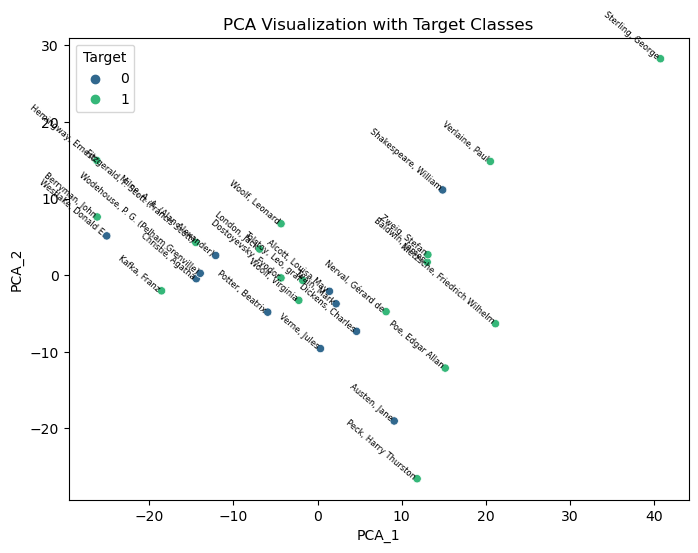

In [139]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
df_author = df.groupby("Author").aggregate({"Embedding":"mean","Target":"mean"})
df_author["Target"] = df_author["Target"].astype(int)
# Extract the embeddings from the DataFrame
embeds = np.vstack(df_author['Embedding'])

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_embeds = scaler.fit_transform(embeds)

pca_model = PCA(n_components=2)
pca_embeds = pca_model.fit_transform(scaled_embeds)

# Add the PCA embeds back to the df_author DataFrame
df_author['PCA_1'] = pca_embeds[:, 0]
df_author['PCA_2'] = pca_embeds[:, 1]

# Create a scatter plot with target as hue
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x='PCA_1', y='PCA_2', hue='Target', data=df_author, palette='viridis')

# Label the points with author names
for i in range(len(df_author)):
    ax.text(df_author['PCA_1'][i], df_author['PCA_2'][i], df_author.index.to_series()[i], fontsize=6, ha='right', rotation=-40)

plt.title("PCA Visualization with Target Classes")
plt.show()


Deep Learning

In [88]:
new_df = df.groupby(["Author","Work"]).head(20).reset_index()
train, val,test = new_df[new_df["Split"] == "train"], new_df[new_df["Split"] == "val"],new_df[new_df["Split"] == "test"]
train_embeddings = embeddings[train.index]
val_embeddings = embeddings[val.index]
test_embeddings = embeddings[test.index]

X_train, X_val, X_test = train_embeddings, val_embeddings, test_embeddings
y_train, y_val, y_test = train["Target"].values,  val["Target"].values,test["Target"].values
print_split_stats(X_train,X_val ,X_test , y_train, y_val,y_test, train, val, test)

data target dist =
 0    0.68855
1    0.31145
Name: Target, dtype: float64
train val test ratio =  0.7085960326003274 0.16915269875441843 0.12225126864523878
train val test target dist =  1    0.53125
0    0.46875
Name: Target, dtype: float64 0    0.527273
1    0.472727
Name: Target, dtype: float64 1    0.603774
0    0.396226
Name: Target, dtype: float64
X_train shape = (4608, 768)
 X_val shape = (1100, 768)
 X_test shape = (795, 768)
 y_train shape = (4608,)
 y_val shape = (1100,)
 y_test shape = (795,)
 train shape = (4608, 7)
 test shape = (795, 7)


(1    0.53125
 0    0.46875
 Name: Target, dtype: float64,
 0    0.527273
 1    0.472727
 Name: Target, dtype: float64,
 1    0.603774
 0    0.396226
 Name: Target, dtype: float64)

data target dist =
 0    0.68855
1    0.31145
Name: Target, dtype: float64
train val test ratio =  0.7085960326003274 0.16915269875441843 0.12225126864523878
train val test target dist =  1    0.53125
0    0.46875
Name: Target, dtype: float64 0    0.527273
1    0.472727
Name: Target, dtype: float64 1    0.603774
0    0.396226
Name: Target, dtype: float64
X_train shape = (4608, 768)
 X_val shape = (1100, 768)
 X_test shape = (795, 768)
 y_train shape = (4608,)
 y_val shape = (1100,)
 y_test shape = (795,)
 train shape = (4608, 7)
 test shape = (795, 7)
Epoch [1/100] - Train Loss: 0.734284381252817
Epoch [1/100] - Validation Loss: 0.7473288919223141
Epoch [2/100] - Train Loss: 0.7947824365562863
Epoch [2/100] - Validation Loss: 0.6847456318971961
Epoch [3/100] - Train Loss: 0.7090836659901671
Epoch [3/100] - Validation Loss: 0.6848509941762703
Epoch [4/100] - Train Loss: 0.7045716523296304
Epoch [4/100] - Validation Loss: 0.6831242884888885
Epoch [5/100] - Train Loss: 0.6988792088296678


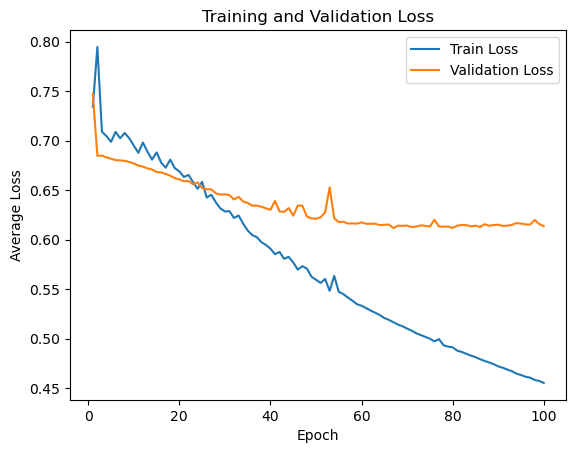

Accuracy: 0.60
Precision: 0.73
Recall: 0.54
F1 Score: 0.62
Cohen's Kappa: 0.22
Matthew's Correlation Coefficient: 0.24
ROC AUC Score: 0.62
Classification Report:



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

         0.0       0.50      0.70      0.58       315
         1.0       0.73      0.54      0.62       480

    accuracy                           0.60       795
   macro avg       0.62      0.62      0.60       795
weighted avg       0.64      0.60      0.61       795

Accuracy: 0.63
Precision: 0.73
Recall: 0.46
F1 Score: 0.56
Cohen's Kappa: 0.27
Matthew's Correlation Coefficient: 0.29
ROC AUC Score: 0.64
Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.82      0.68        22
         1.0       0.73      0.46      0.56        24

    accuracy                           0.63        46
   macro avg       0.66      0.64      0.62        46
weighted avg       0.66      0.63      0.62        46



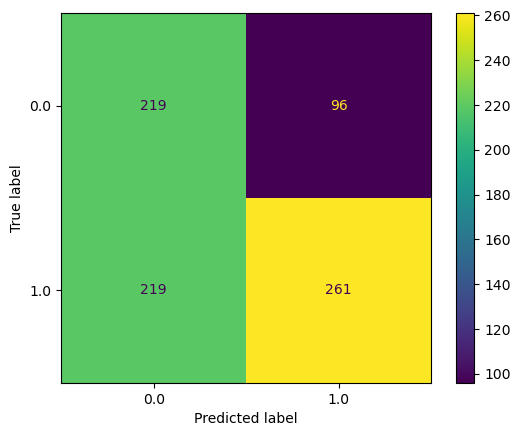

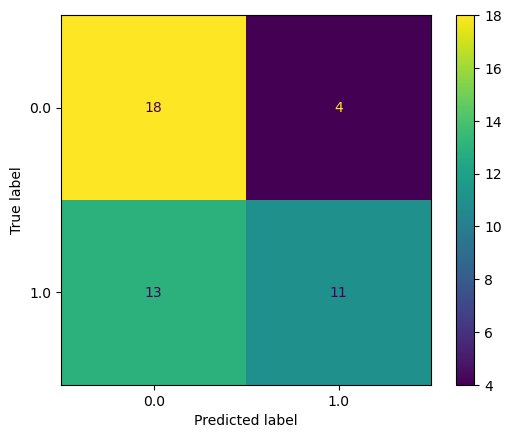

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
train,val,test = new_df[new_df["Split"] == "train"], new_df[new_df["Split"] == "val"],new_df[new_df["Split"] == "test"]

train_embeddings = embeddings[train.index]
val_embeddings = embeddings[val.index]
test_embeddings = embeddings[test.index]

X_train, X_val, X_test = train_embeddings, val_embeddings, test_embeddings
y_train, y_val, y_test = train["Target"].values,  val["Target"].values,test["Target"].values
print_split_stats(X_train,X_val ,X_test , y_train, y_val,y_test, train, val, test)

X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
X_val = torch.tensor(X_val, dtype=torch.float32).cuda()
X_test = torch.tensor(X_test, dtype=torch.float32).cuda()

y_train = torch.tensor(y_train, dtype=torch.float32).cuda()
y_val = torch.tensor(y_val, dtype=torch.float32).cuda()
y_test = torch.tensor(y_test, dtype=torch.float32).cuda()

class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Define the dimensions
input_dim = 768  # Size of BERT embeddings
hidden_dim = 256  # Adjust this as needed
output_dim = 1  # Binary classification

# Create an instance of the model
model = BinaryClassificationModel(input_dim, hidden_dim, output_dim).cuda()

# Loss and optimizer
criterion = torch.nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop (you may need to adjust batch size and epochs)
epochs = 100
batch_size = 32

# Lists to store losses for each epoch
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0

for epoch in range(epochs):
    # Lists to store losses for each batch in the current epoch
    train_batch_losses = []
    
    # Training loop
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        train_batch_losses.append(loss.item())  # Store the batch loss
        loss.backward()
        optimizer.step()
    
    # Calculate and store the average training loss for the epoch
    avg_train_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss}")
    
    # Validation loop
    val_batch_losses = []
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            val_inputs = X_val[i:i+batch_size]
            val_labels = y_val[i:i+batch_size]

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs.squeeze(), val_labels)
            val_batch_losses.append(val_loss.item())  # Store the validation batch loss
    
    # Calculate and store the average validation loss for the epoch
    avg_val_loss = sum(val_batch_losses) / (len(val_batch_losses) + 1e-10)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping. Loading best model.")
        model.load_state_dict(torch.load('best_model.pth'))
        break

# Plot the training and validation losses
plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

probabilities = model(X_test)
probabilities = probabilities.cpu().detach().numpy()
class_predictions = (probabilities >= 0.5)
nn_preds = class_predictions*1.0
test["NN Preds"] = nn_preds
test_vals = np.round(test.groupby(["Author","Work"])[["Target","NN Preds"]].mean().values)
y_true, pred = test_vals[:,0], test_vals[:,1]
print_classification_metrics(y_test.cpu().detach().numpy(),nn_preds,[0,1])  
print_classification_metrics(y_true,pred,[0,1])  

Copying these to the main notebook

In [102]:
pred_val

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1.])

In [101]:
pred_test

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])